In [14]:
import torch
from torchvision import transforms, utils
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import glob
import random
import os
import numpy as np
import argparse
import math

In [15]:
# Setting
# =dataset position=
dataset_dir = './dataset_2_1/'

Train_Path = f'./{dataset_dir}/train'
Test_Path = f'./{dataset_dir}/test'
Generate_Path = f'./{dataset_dir}/generate'

# =modeltag and ouputtag
TAG = 'D02'
output_TAG = ""

# =training epochs=
model_epochs = list(range(0, 1001, 100))
# model_epochs = [0, 5, 10]

In [16]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())



PyTorch version: 2.5.1
CUDA version: 12.4
CUDA available: True
Device count: 1


In [17]:
# !git clone https://github.com/ryanliwag/temp.git

In [18]:
# Dataset loader
transforms_orig = transforms.Compose([
                transforms.RandomRotation(15),
                transforms.Resize((128, 128), Image.BICUBIC),
                transforms.RandomHorizontalFlip()])

transforms_bw = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()])


transforms_rgb = transforms.Compose([
                transforms.ToTensor()])

class ImageDataset(Dataset):
    def __init__(self, root, transforms_orig=None, transforms_bw=None, transforms_rgb=None):
        '''
        Args:
            csv_file (string)
            transform (callable, optional)
        '''
        
        files = glob.glob('%s/*.*' % root)
        self.training_files = files * 4
        self.transforms_orig = transforms_orig
        self.transforms_rgb = transforms_rgb
        self.transforms_bw = transforms_bw
        
    def __len__(self):
        return len(self.training_files)
    
    def __getitem__(self, idx):
        img = Image.open(self.training_files[idx])
        
        orig_image = self.transforms_orig(img)
        
        true_image = self.transforms_rgb(orig_image)
        bw_image = self.transforms_bw(orig_image)
        
        return {"true_image": true_image, "gen_image": bw_image}

In [19]:
# training_generator = ImageDataset(root="./training", transforms_orig=transforms_orig,
#                                                     transforms_rgb=transforms_rgb, 
#                                                     transforms_bw=transforms_bw)
training_generator = ImageDataset(root=Train_Path, transforms_orig=transforms_orig,
                                                    transforms_rgb=transforms_rgb, 
                                                    transforms_bw=transforms_bw)


In [20]:
batch_size = 4
dataloader = DataLoader(
    training_generator,
    batch_size=batch_size,
    shuffle=True
)

4
0
torch.Size([4, 3, 128, 128])


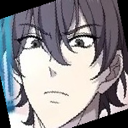

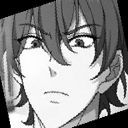

1
torch.Size([4, 3, 128, 128])


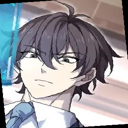

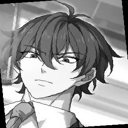

2
torch.Size([4, 3, 128, 128])


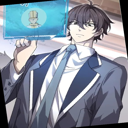

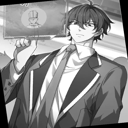

3
torch.Size([4, 3, 128, 128])


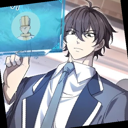

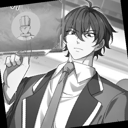

In [21]:
to_pil = torchvision.transforms.ToPILImage()
print(len(dataloader))
for idx, image in enumerate(dataloader):
    res = to_pil(image["true_image"][0])
    bw = to_pil(image["gen_image"][0])
    print(idx)
    print(image["true_image"].shape)
    display(res)
    display(bw)
    # if idx == 2:
    #     break

In [22]:
  class UNet(nn.Module):
    
    def unet_conv(self, ch_in, ch_out, is_leaky):
        """
        Construct a convolutional unit comprising of two conv layers
        followed by a batch normalisation layer and ReLU/Leaky ReLU.
        """
        if is_leaky:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU(),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU()
            )
        
    def up(self, ch_in, ch_out):
        """
        Applies a 2D bilinear upsampling to the input image which scales
        the image 2x times, followed by a convolution with a 1x1 kernel. 
        """
        return nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, 1), 
            nn.ReLU()
        )
    
    def __init__(self, is_leaky):
        """
        In the constructer, all the convolutional, upsampling and max pooling 
        units are instantiated and assigned as member variables. 
        """
        super(UNet, self).__init__()
        
        # First encoding layer
        self.conv1 = self.unet_conv(1, 64, is_leaky)
        # Second encoding layer
        self.conv2 = self.unet_conv(64, 128, is_leaky)
        # Third encoding layer
        self.conv3 = self.unet_conv(128, 256, is_leaky)
        # Fourth encoding layer
        self.conv4 = self.unet_conv(256, 512, is_leaky)
        # Fifth encoding layer
        self.conv5 = self.unet_conv(512, 1024, is_leaky)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        # First Upsampling layer
        self.up1 = self.up(1024, 512)
        # Second Upsampling layer
        self.up2 = self.up(512, 256)
        # Third Upsampling layer
        self.up3 = self.up(256, 128)
        # Fourth Upsampling layer
        self.up4 = self.up(128, 64)
        
        # First decoding layer
        self.conv6 = self.unet_conv(1024, 512, False)
        # Second decoding layer
        self.conv7 = self.unet_conv(512, 256, False)
        # Third decoding layer
        self.conv8 = self.unet_conv(256, 128, False)
        # Fourth decoding layer
        self.conv9 = self.unet_conv(128, 64, False)
        
        # Last layer
        self.conv10 = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        """ 
        An input tensor of a black and white image is accepted and
        passed through the U-Net model. A colored image in CieLAB color
        space is returned as the result. 
        """
        # Encoding path
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))
        
        # Decoding path
        x = self.conv6(torch.cat((x4, self.up1(x5)), 1))
        x = self.conv7(torch.cat((x3, self.up2(x)), 1))
        x = self.conv8(torch.cat((x2, self.up3(x)), 1))
        x = self.conv9(torch.cat((x1, self.up4(x)), 1))
        x = self.conv10(x)
        m = nn.Tanh()
        x = m(x)
        
        return x


class DNet(nn.Module):
    
    def unet_conv(self, ch_in, ch_out, generator_output=True):
        """
        Construct a convolutional unit comprising of two conv layers
        followed by a batch normalisation layer and Leaky ReLU.
        """
        

        return nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ch_out, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2)
        )


    
    def __init__(self):
        super(DNet, self).__init__()
        """
        In the constructer, all the convolutional and max pooling units 
        are instantiated and assigned as member variables. 
        """
        # First layer
        self.conv1_x = self.unet_conv(3, 64)
        
        self.conv1_y = self.unet_conv(1, 64)
        
        # Second layer
        self.conv2 = self.unet_conv(64, 128)
        # Third layer
        self.conv3 = self.unet_conv(128, 256)
        # Fourth layer
        self.conv4 = self.unet_conv(256, 512)
        # Fifth layer
        self.conv5 = self.unet_conv(512, 1024)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        # Last layer
        self.conv6 = nn.Linear(1024 * 128 * 2, 1)

    def forward(self, x_rgb, x_bw):
        """ 
        An input tensor of a colored image from either the generator or source
        is accepted and passed through the model. The probability of the image
        belonging to the source domain is returned as the result. 
        """
        x1_rgb = self.conv1_x(x_rgb)
        x2_rgb = self.conv2(self.pool(x1_rgb))
        
        x1_bw = self.conv1_y(x_bw)
        x2_bw = self.conv2(self.pool(x1_bw))     
        
        x2 = torch.cat((x2_rgb, x2_bw), 1)
        x4 = self.conv4(self.pool(x2))
        x5 = self.conv5(self.pool(x4))

        x6 = x5.view(batch_size, -1)
        m = nn.Sigmoid()
        x = m(self.conv6(x6))
        
        return x

In [23]:
generator = 0
discriminator = 0
d_optimizer = 0
g_optimizer = 0
torch.cuda.empty_cache()

In [24]:

##############################################################
# Initialise the generator and discriminator with the UNet and
# DNet architectures respectively.
generator = UNet(True)
discriminator = DNet()

##################################################################
# Utilize GPU for performing all the calculations performed in the
# forward and backward passes. Thus allocate all the generator and
# discriminator variables on the default GPU device.




generator.to(device)
discriminator.to(device)

###################################################################
# Create ADAM optimizer for the generator as well the discriminator.
# Create loss criterion for calculating the L1 and adversarial loss.
d_optimizer = optim.Adam(discriminator.parameters(), betas=(0.5, 0.999), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), betas=(0.5, 0.999), lr=0.0002)

d_criterion = nn.BCELoss()
g_criterion_1 = nn.BCELoss()
g_criterion_2 = nn.L1Loss()

In [25]:
def train(PATH, ori_epoch=0, total_epoch=200, TAG=""):
    g_lambda = 100
    smooth = 0.1
    if ori_epoch != 0:
      generator.load_state_dict(torch.load(f"./models/generator_epoch_{ori_epoch}_{TAG}.pth", map_location=torch.device('cuda'), weights_only=False))
      discriminator.load_state_dict(torch.load(f'./models/discriminator_epoch_{ori_epoch}_{TAG}.pth', map_location=torch.device('cuda'), weights_only=False))

    loss_list = []
    for epoch in range(ori_epoch+1, total_epoch+1):
      print("epoch_{}".format(epoch))
        # the generator and discriminator losses are summed for the entire epoch.
      d_running_loss = 0.0
      g_running_loss = 0.0
      for i, data in enumerate(dataloader):
          images = data
          true_images = images["true_image"].to(device)
          bw_images = images["gen_image"].to(device)

#             print(true_images.shape, bw_images.shape)
          fake_images = generator(bw_images)

          d_optimizer.zero_grad()
          d_loss = 0
          
          # print(true_images.shape)
          logits = discriminator(true_images, bw_images)
          
          # d_real_loss = d_criterion(logits, ((1 - smooth) * torch.ones(batch_size)).to(device)) # [5,1], [5]
          # d_real_loss = d_criterion(logits.reshape((-1)), ((1 - smooth) * torch.ones(batch_size)).to(device)) # [5]
          d_real_loss = d_criterion(logits, ((1 - smooth) * torch.ones(batch_size)).reshape((batch_size,1)).to(device)) # [5, 1]
          
          logits = discriminator(fake_images, bw_images)
          # d_fake_loss = d_criterion(logits, (torch.zeros(batch_size)).to(device))
          d_fake_loss = d_criterion(logits, (torch.zeros(batch_size)).reshape((batch_size,1)).to(device))

          d_loss = d_real_loss + d_fake_loss
          d_loss.backward(retain_graph=True)
          d_optimizer.step()

          # Train the generator. The loss would be the sum of the adversarial loss
          # due to the GAN and L1 distance loss between the fake and target images. 
          g_optimizer.zero_grad()
          g_loss = 0
          fake_logits = discriminator(fake_images, bw_images)
          # g_fake_loss = g_criterion_1(fake_logits, (torch.ones(batch_size)).to(device))
          g_fake_loss = g_criterion_1(fake_logits, (torch.ones(batch_size)).reshape((batch_size,1)).to(device))

          g_image_distance_loss = g_lambda * g_criterion_2(fake_images, true_images)

          g_loss = g_fake_loss + g_image_distance_loss
          g_loss.backward()
          g_optimizer.step()

          d_running_loss += d_loss
          g_running_loss += g_loss
          
      loss_text = '[%d, %5d] d_loss: %.5f g_loss: %.5f' % (epoch, i + 1, d_running_loss / 10, g_running_loss / 10)
      print(loss_text)
      loss_list.append(loss_text)
      d_running_loss = 0.0
      g_running_loss = 0.0
            
    #save generator and didscriminator
    torch.save(generator.state_dict(), os.path.join(PATH, "generator_epoch_{}_{}.pth".format(total_epoch, TAG)))
    torch.save(discriminator.state_dict(), os.path.join(PATH, "discriminator_epoch_{}_{}.pth".format(total_epoch, TAG)))
    with open(f'./logs/epoch_{total_epoch}.txt', 'w') as f:
      for text in loss_list:
        f.write(f'{text}\n')

In [26]:
# Train the cGAN
for idx in range(len(model_epochs)-1):
    train("./models", ori_epoch=model_epochs[idx], total_epoch=model_epochs[idx+1], TAG=TAG)

epoch_1
[1,     4] d_loss: 1.92819 g_loss: 26.46057
epoch_2
[2,     4] d_loss: 5.89510 g_loss: 22.46338
epoch_3
[3,     4] d_loss: 1.72052 g_loss: 19.96155
epoch_4
[4,     4] d_loss: 2.06856 g_loss: 15.91053
epoch_5
[5,     4] d_loss: 2.90803 g_loss: 15.34590
epoch_6
[6,     4] d_loss: 1.79346 g_loss: 13.91446
epoch_7
[7,     4] d_loss: 3.02575 g_loss: 15.20190
epoch_8
[8,     4] d_loss: 1.53985 g_loss: 12.17668
epoch_9
[9,     4] d_loss: 1.89878 g_loss: 11.13370
epoch_10
[10,     4] d_loss: 0.80397 g_loss: 12.93160
epoch_11
[11,     4] d_loss: 2.07012 g_loss: 11.68403
epoch_12
[12,     4] d_loss: 0.57256 g_loss: 12.14760
epoch_13
[13,     4] d_loss: 0.58251 g_loss: 12.75337
epoch_14
[14,     4] d_loss: 1.82290 g_loss: 13.04415
epoch_15
[15,     4] d_loss: 0.76242 g_loss: 10.12082
epoch_16
[16,     4] d_loss: 0.71146 g_loss: 10.85039
epoch_17
[17,     4] d_loss: 1.28289 g_loss: 10.24877
epoch_18
[18,     4] d_loss: 1.05069 g_loss: 7.74569
epoch_19
[19,     4] d_loss: 0.87400 g_loss: 8.

# Generate Colored Images



In [27]:
# test_images_path = "./test_images"
# generated_images_path = "./generated_images"
# test_images_path = "./_my_img/test_crop_jpg"
# generated_images_path = "./_my_img/generated_img"
test_images_path = Test_Path
images_path = [file for file in os.listdir(test_images_path) if file.endswith(".jpg")]

100
1.jpg


/tmp/ipykernel_174707/646389669.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_test.load_state_dict(torch.load(f"./models/generator_epoch_{total_epoch}_{TAG}.

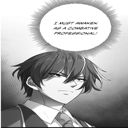

././dataset_2_1//generate/gen_image_1_epoch_100_D02.png
7.jpg


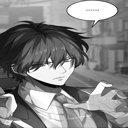

././dataset_2_1//generate/gen_image_2_epoch_100_D02.png
4.jpg


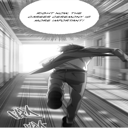

././dataset_2_1//generate/gen_image_3_epoch_100_D02.png
10.jpg


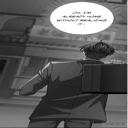

././dataset_2_1//generate/gen_image_4_epoch_100_D02.png
2.jpg


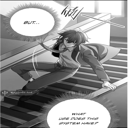

././dataset_2_1//generate/gen_image_5_epoch_100_D02.png
9.jpg


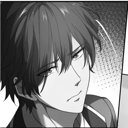

././dataset_2_1//generate/gen_image_6_epoch_100_D02.png
5.jpg


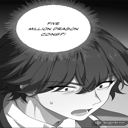

././dataset_2_1//generate/gen_image_7_epoch_100_D02.png
8.jpg


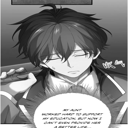

././dataset_2_1//generate/gen_image_8_epoch_100_D02.png
6.jpg


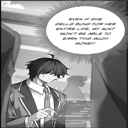

././dataset_2_1//generate/gen_image_9_epoch_100_D02.png
3.jpg


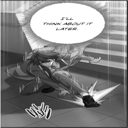

././dataset_2_1//generate/gen_image_10_epoch_100_D02.png
200
1.jpg


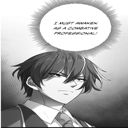

././dataset_2_1//generate/gen_image_1_epoch_200_D02.png
7.jpg


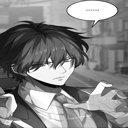

././dataset_2_1//generate/gen_image_2_epoch_200_D02.png
4.jpg


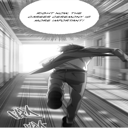

././dataset_2_1//generate/gen_image_3_epoch_200_D02.png
10.jpg


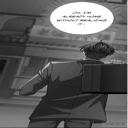

././dataset_2_1//generate/gen_image_4_epoch_200_D02.png
2.jpg


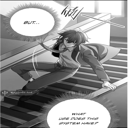

././dataset_2_1//generate/gen_image_5_epoch_200_D02.png
9.jpg


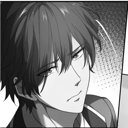

././dataset_2_1//generate/gen_image_6_epoch_200_D02.png
5.jpg


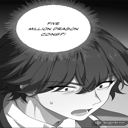

././dataset_2_1//generate/gen_image_7_epoch_200_D02.png
8.jpg


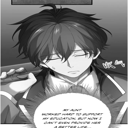

././dataset_2_1//generate/gen_image_8_epoch_200_D02.png
6.jpg


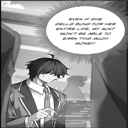

././dataset_2_1//generate/gen_image_9_epoch_200_D02.png
3.jpg


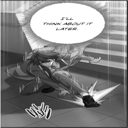

././dataset_2_1//generate/gen_image_10_epoch_200_D02.png
300
1.jpg


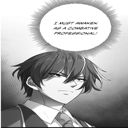

././dataset_2_1//generate/gen_image_1_epoch_300_D02.png
7.jpg


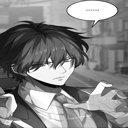

././dataset_2_1//generate/gen_image_2_epoch_300_D02.png
4.jpg


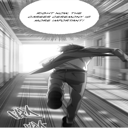

././dataset_2_1//generate/gen_image_3_epoch_300_D02.png
10.jpg


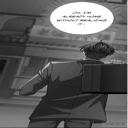

././dataset_2_1//generate/gen_image_4_epoch_300_D02.png
2.jpg


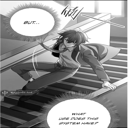

././dataset_2_1//generate/gen_image_5_epoch_300_D02.png
9.jpg


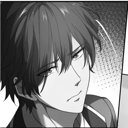

././dataset_2_1//generate/gen_image_6_epoch_300_D02.png
5.jpg


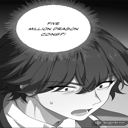

././dataset_2_1//generate/gen_image_7_epoch_300_D02.png
8.jpg


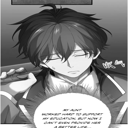

././dataset_2_1//generate/gen_image_8_epoch_300_D02.png
6.jpg


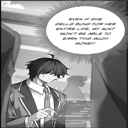

././dataset_2_1//generate/gen_image_9_epoch_300_D02.png
3.jpg


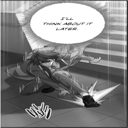

././dataset_2_1//generate/gen_image_10_epoch_300_D02.png
400
1.jpg


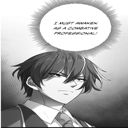

././dataset_2_1//generate/gen_image_1_epoch_400_D02.png
7.jpg


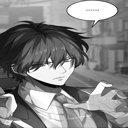

././dataset_2_1//generate/gen_image_2_epoch_400_D02.png
4.jpg


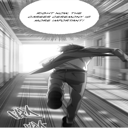

././dataset_2_1//generate/gen_image_3_epoch_400_D02.png
10.jpg


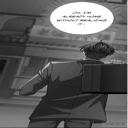

././dataset_2_1//generate/gen_image_4_epoch_400_D02.png
2.jpg


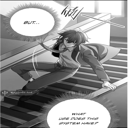

././dataset_2_1//generate/gen_image_5_epoch_400_D02.png
9.jpg


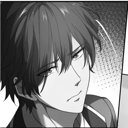

././dataset_2_1//generate/gen_image_6_epoch_400_D02.png
5.jpg


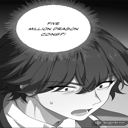

././dataset_2_1//generate/gen_image_7_epoch_400_D02.png
8.jpg


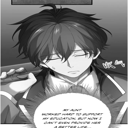

././dataset_2_1//generate/gen_image_8_epoch_400_D02.png
6.jpg


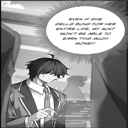

././dataset_2_1//generate/gen_image_9_epoch_400_D02.png
3.jpg


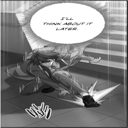

././dataset_2_1//generate/gen_image_10_epoch_400_D02.png
500
1.jpg


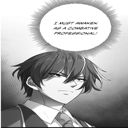

././dataset_2_1//generate/gen_image_1_epoch_500_D02.png
7.jpg


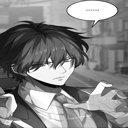

././dataset_2_1//generate/gen_image_2_epoch_500_D02.png
4.jpg


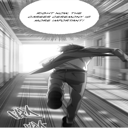

././dataset_2_1//generate/gen_image_3_epoch_500_D02.png
10.jpg


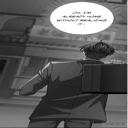

././dataset_2_1//generate/gen_image_4_epoch_500_D02.png
2.jpg


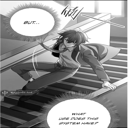

././dataset_2_1//generate/gen_image_5_epoch_500_D02.png
9.jpg


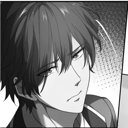

././dataset_2_1//generate/gen_image_6_epoch_500_D02.png
5.jpg


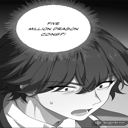

././dataset_2_1//generate/gen_image_7_epoch_500_D02.png
8.jpg


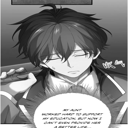

././dataset_2_1//generate/gen_image_8_epoch_500_D02.png
6.jpg


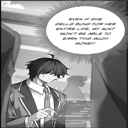

././dataset_2_1//generate/gen_image_9_epoch_500_D02.png
3.jpg


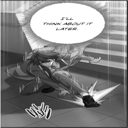

././dataset_2_1//generate/gen_image_10_epoch_500_D02.png
600
1.jpg


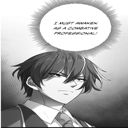

././dataset_2_1//generate/gen_image_1_epoch_600_D02.png
7.jpg


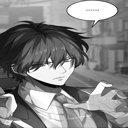

././dataset_2_1//generate/gen_image_2_epoch_600_D02.png
4.jpg


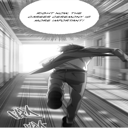

././dataset_2_1//generate/gen_image_3_epoch_600_D02.png
10.jpg


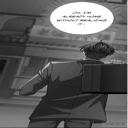

././dataset_2_1//generate/gen_image_4_epoch_600_D02.png
2.jpg


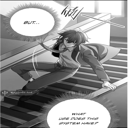

././dataset_2_1//generate/gen_image_5_epoch_600_D02.png
9.jpg


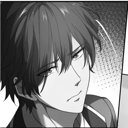

././dataset_2_1//generate/gen_image_6_epoch_600_D02.png
5.jpg


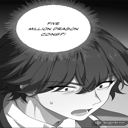

././dataset_2_1//generate/gen_image_7_epoch_600_D02.png
8.jpg


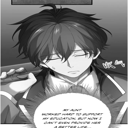

././dataset_2_1//generate/gen_image_8_epoch_600_D02.png
6.jpg


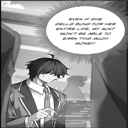

././dataset_2_1//generate/gen_image_9_epoch_600_D02.png
3.jpg


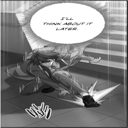

././dataset_2_1//generate/gen_image_10_epoch_600_D02.png
700
1.jpg


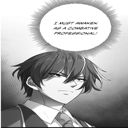

././dataset_2_1//generate/gen_image_1_epoch_700_D02.png
7.jpg


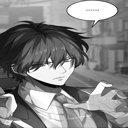

././dataset_2_1//generate/gen_image_2_epoch_700_D02.png
4.jpg


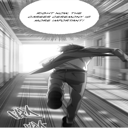

././dataset_2_1//generate/gen_image_3_epoch_700_D02.png
10.jpg


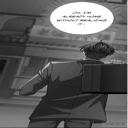

././dataset_2_1//generate/gen_image_4_epoch_700_D02.png
2.jpg


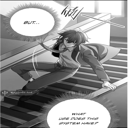

././dataset_2_1//generate/gen_image_5_epoch_700_D02.png
9.jpg


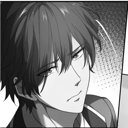

././dataset_2_1//generate/gen_image_6_epoch_700_D02.png
5.jpg


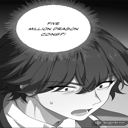

././dataset_2_1//generate/gen_image_7_epoch_700_D02.png
8.jpg


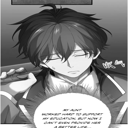

././dataset_2_1//generate/gen_image_8_epoch_700_D02.png
6.jpg


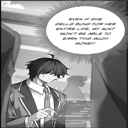

././dataset_2_1//generate/gen_image_9_epoch_700_D02.png
3.jpg


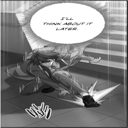

././dataset_2_1//generate/gen_image_10_epoch_700_D02.png
800
1.jpg


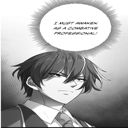

././dataset_2_1//generate/gen_image_1_epoch_800_D02.png
7.jpg


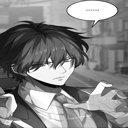

././dataset_2_1//generate/gen_image_2_epoch_800_D02.png
4.jpg


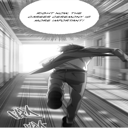

././dataset_2_1//generate/gen_image_3_epoch_800_D02.png
10.jpg


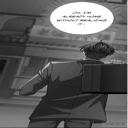

././dataset_2_1//generate/gen_image_4_epoch_800_D02.png
2.jpg


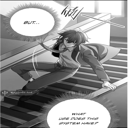

././dataset_2_1//generate/gen_image_5_epoch_800_D02.png
9.jpg


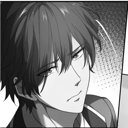

././dataset_2_1//generate/gen_image_6_epoch_800_D02.png
5.jpg


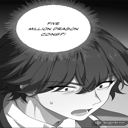

././dataset_2_1//generate/gen_image_7_epoch_800_D02.png
8.jpg


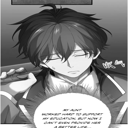

././dataset_2_1//generate/gen_image_8_epoch_800_D02.png
6.jpg


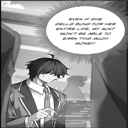

././dataset_2_1//generate/gen_image_9_epoch_800_D02.png
3.jpg


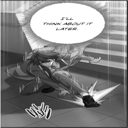

././dataset_2_1//generate/gen_image_10_epoch_800_D02.png
900
1.jpg


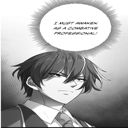

././dataset_2_1//generate/gen_image_1_epoch_900_D02.png
7.jpg


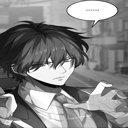

././dataset_2_1//generate/gen_image_2_epoch_900_D02.png
4.jpg


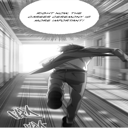

././dataset_2_1//generate/gen_image_3_epoch_900_D02.png
10.jpg


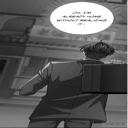

././dataset_2_1//generate/gen_image_4_epoch_900_D02.png
2.jpg


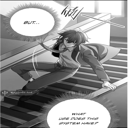

././dataset_2_1//generate/gen_image_5_epoch_900_D02.png
9.jpg


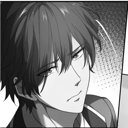

././dataset_2_1//generate/gen_image_6_epoch_900_D02.png
5.jpg


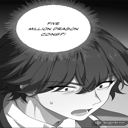

././dataset_2_1//generate/gen_image_7_epoch_900_D02.png
8.jpg


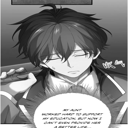

././dataset_2_1//generate/gen_image_8_epoch_900_D02.png
6.jpg


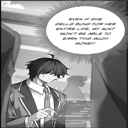

././dataset_2_1//generate/gen_image_9_epoch_900_D02.png
3.jpg


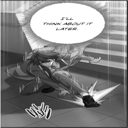

././dataset_2_1//generate/gen_image_10_epoch_900_D02.png
1000
1.jpg


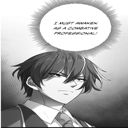

././dataset_2_1//generate/gen_image_1_epoch_1000_D02.png
7.jpg


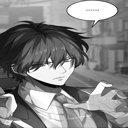

././dataset_2_1//generate/gen_image_2_epoch_1000_D02.png
4.jpg


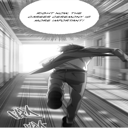

././dataset_2_1//generate/gen_image_3_epoch_1000_D02.png
10.jpg


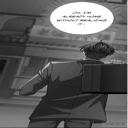

././dataset_2_1//generate/gen_image_4_epoch_1000_D02.png
2.jpg


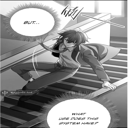

././dataset_2_1//generate/gen_image_5_epoch_1000_D02.png
9.jpg


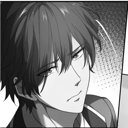

././dataset_2_1//generate/gen_image_6_epoch_1000_D02.png
5.jpg


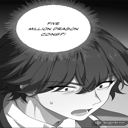

././dataset_2_1//generate/gen_image_7_epoch_1000_D02.png
8.jpg


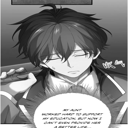

././dataset_2_1//generate/gen_image_8_epoch_1000_D02.png
6.jpg


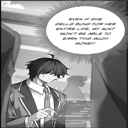

././dataset_2_1//generate/gen_image_9_epoch_1000_D02.png
3.jpg


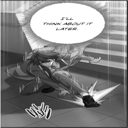

././dataset_2_1//generate/gen_image_10_epoch_1000_D02.png


In [28]:
for i in model_epochs[1:]:
  print(i)
  # load generator weights and parameters
  generator_test = UNet(True)
  generator_test.to(device)
  total_epoch = i
  generator_test.load_state_dict(torch.load(f"./models/generator_epoch_{total_epoch}_{TAG}.pth", map_location=torch.device('cpu')))
  generator_test.eval()
  for idx, img_path in enumerate(images_path):
    img = Image.open(os.path.join(test_images_path, img_path))
    print(img_path)
    

    img = img.resize((128,128))
    
    # img_gray = to_grayscale(img)
    img_gray = img.convert('L')
    display(img_gray)

    # img_tensor = to_tensor(img_gray)
    transforms_bw = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    img_tensor = transforms_bw(img)

    c, h, w, = img_tensor.size()
    gen_input = img_tensor.view(1,c,h,w) #adding 1 more dim
    gen_gpu = gen_input.to(device)
    gen_output = generator_test(gen_gpu)

    output_image = to_pil(gen_output.view(3, h, w).cpu())
    output_img_path = "{}{}/gen_image_{}_epoch_{}_{}.png".format(Generate_Path, output_TAG, idx+1, i, TAG)
    print(output_img_path)
    output_image.save(output_img_path)
    # display(output_image)